In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf # This tells Colab that we are using TensorFlow

from tensorflow import keras # This is the main TensorFlow library
from tensorflow.keras import layers # We are building a Neural Network with several hidden layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense

print("Current TensorFlow version is", tf.__version__)


Current TensorFlow version is 2.8.2


In [ ]:
data_wnv = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/West_Nile_Virus__WNV__Mosquito_Test_Results.csv")
data_wnv.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION
0,2014,39,40542,100XX W OHARE AIRPORT,T902,GRAVID,09/25/2014 12:09:00 AM,8,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
1,2016,37,44219,100XX W OHARE AIRPORT,T902,GRAVID,09/15/2016 12:09:00 AM,39,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
2,2017,33,45351,100XX W OHARE AIRPORT,T905,GRAVID,08/17/2017 12:08:00 AM,50,positive,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
3,2017,33,45345,100XX W OHARE AIRPORT,T900,GRAVID,08/17/2017 12:08:00 AM,17,positive,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
4,2016,37,44169,4XX W 127TH,T135,GRAVID,09/15/2016 12:09:00 AM,12,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN


In [ ]:
data_wnv['RESULT'] = data_wnv['RESULT'].astype('category')
data_wnv['RESULT'] = data_wnv['RESULT'].cat.codes

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
#Standardize

x = data_wnv['RESULT'].values
scaler = StandardScaler()

data_wnv['RESULT'] = scaler.fit_transform(np.reshape(x,(-1,1)))
data_wnv['RESULT']

0       -0.303554
1       -0.303554
2        3.294312
3        3.294312
4       -0.303554
           ...   
29484   -0.303554
29485   -0.303554
29486   -0.303554
29487   -0.303554
29488   -0.303554
Name: RESULT, Length: 29489, dtype: float64

In [ ]:
bins = np.linspace(data_wnv['NUMBER OF MOSQUITOES'].min(),data_wnv['NUMBER OF MOSQUITOES'].max(),6)

labels = ['xs','s','m','l','xl']

data_wnv['NUMBER OF MOSQUITOES'] = pd.cut(data_wnv['NUMBER OF MOSQUITOES'] , bins=bins, labels=labels, include_lowest=True)

In [ ]:
data_wnv['NUMBER OF MOSQUITOES'].value_counts()

xs    22212
s      3036
l      2573
m      1667
xl        1
Name: NUMBER OF MOSQUITOES, dtype: int64

In [ ]:
data_wnv.LONGITUDE.replace(np.nan,'null',inplace=True)

In [ ]:
data_wnv['LONGITUDE'].isnull().sum()

0

In [ ]:
data_wnv['WEEK'].describe()

count    29489.000000
mean        31.073587
std          4.533390
min         20.000000
25%         28.000000
50%         31.000000
75%         35.000000
max         40.000000
Name: WEEK, dtype: float64

In [ ]:
train_data_wnvset = data_wnv.sample(frac=0.8, random_state=0)
test_data_wnvset = data_wnv.drop(train_data_wnvset.index)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_wnv, test_size = 0.2)

In [ ]:
data_wnv[['SEASON YEAR','RESULT','WEEK']].corr()

,SEASON YEAR,RESULT,WEEK
SEASON YEAR,1.000000,0.095773,0.005214
RESULT,0.095773,1.000000,0.095540
WEEK,0.005214,0.095540,1.000000


In [ ]:
data_wnv1 = data_wnv[['WEEK', 'TRAP_TYPE','NUMBER OF MOSQUITOES', 'RESULT','SPECIES','LOCATION']]

data_wnv1['TRAP_TYPE'] = data_wnv1['TRAP_TYPE'].astype('category')
data_wnv1['TRAP_TYPE'] = data_wnv1['TRAP_TYPE'].cat.codes

data_wnv1['SPECIES'] = data_wnv1['SPECIES'].astype('category')
data_wnv1['SPECIES'] = data_wnv1['SPECIES'].cat.codes

data_wnv1['LOCATION'] = data_wnv1['LOCATION'].astype('category')
data_wnv1['LOCATION'] = data_wnv1['LOCATION'].cat.codes


,WEEK,TRAP_TYPE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LOCATION
0,39,1,xs,-0.303554,2,-1
1,37,1,m,-0.303554,2,-1
2,33,1,l,3.294312,2,-1
3,33,1,s,3.294312,2,-1
4,37,1,xs,-0.303554,2,-1


In [ ]:
train_data_wnvset = data_wnv1.sample(frac=0.8, random_state=0)
test_data_wnvset = data_wnv1.drop(train_data_wnvset.index)

# Splitting Features from Labels
train_features = train_data_wnvset.copy()
test_features = test_data_wnvset.copy()

train_labels = train_features.pop('NUMBER OF MOSQUITOES')
test_labels = test_features.pop('NUMBER OF MOSQUITOES')

In [ ]:
# Encoding the output variable with pd.get_dummies
train_labels1 = pd.get_dummies(train_labels, columns=['NUMBER OF MOSQUITOES'], prefix='', prefix_sep='')

# Normalizing the input variables
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [ ]:
test_labels1 = pd.get_dummies(test_labels,columns=['NUMBER OF MOSQUITOES'],prefix='', prefix_sep='')
normalizer.adapt(np.array(train_features))

In [ ]:
# define the Keras model
model = Sequential(normalizer)
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 12)                72        
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 232
Trainable params: 221
Non-trainable params: 11
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
model.fit(train_features, train_labels1, epochs=150, batch_size=10)

Epoch 1/150
2360/2360 [==============================] - 5s 2ms/step - loss: 0.8067 - accuracy: 0.7473
Epoch 2/150
2360/2360 [==============================] - 4s 2ms/step - loss: 0.7160 - accuracy: 0.7710
Epoch 3/150
2360/2360 [==============================] - 4s 2ms/step - loss: 0.7083 - accuracy: 0.7725
Epoch 4/150
2360/2360 [==============================] - 4s 2ms/step - loss: 0.7054 - accuracy: 0.7739
Epoch 5/150
2360/2360 [==============================] - 5s 2ms/step - loss: 0.7034 - accuracy: 0.7737
Epoch 6/150
2360/2360 [==============================] - 7s 3ms/step - loss: 0.7026 - accuracy: 0.7742
Epoch 7/150
2360/2360 [==============================] - 9s 4ms/step - loss: 0.7016 - accuracy: 0.7737
Epoch 8/150
2360/2360 [==============================] - 7s 3ms/step - loss: 0.7013 - accuracy: 0.7740
Epoch 9/150
2360/2360 [==============================] - 7s 3ms/step - loss: 0.7007 - accuracy: 0.7734
Epoch 10/150
2360/2360 [==============================] - 4s 2ms/step - l

In [ ]:
# evaluate the keras model
accuracy = model.evaluate(test_features, test_labels1)
print('Accuracy: %.2f' % (accuracy[1]*100))

185/185 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.7748
Accuracy: 77.48


In [ ]:
y_pred = model.predict(test_features)

In [ ]:
from sklearn.metrics import plot_confusion_matrix,classification_report, confusion_matrix, multilabel_confusion_matrix
cm = confusion_matrix(np.argmax(np.array(test_labels1),axis=1),np.argmax(y_pred,axis=1))

In [ ]:
import seaborn as sns

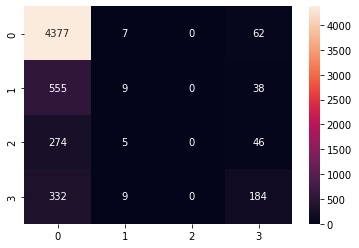

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
print(classification_report(np.argmax(np.array(test_labels1),axis=1),np.argmax(y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4446
           1       0.30      0.01      0.03       602
           2       0.00      0.00      0.00       325
           3       0.56      0.35      0.43       525

    accuracy                           0.77      5898
   macro avg       0.41      0.34      0.33      5898
weighted avg       0.68      0.77      0.70      5898



In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Elbow method

def elbow_plot(data_wnv, maxK=10, seed_centroids=None):
    """
        parameters:
        - data_wnv: pandas data_wnvFrame (data_wnv to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data_wnv)
            data_wnv["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data_wnv)
            data_wnv["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

k:  1
k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9


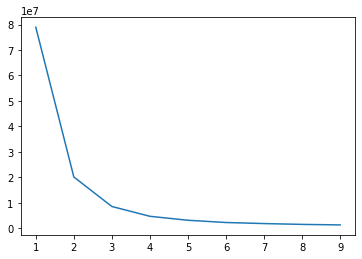

In [ ]:
df = train_features.append(test_features)
elbow_plot(df,maxK=10)

In [ ]:
KMeans(n_clusters=3, ).fit(train_features.append(test_features))

KMeans(n_clusters=3)